# Required Dependencies

In [8]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
import matplotlib.pyplot as plt
import numpy as np
import math
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
import random

# Exploratory Data Analysis

In [9]:
# loading the datasets 
ratings_1m=pd.read_csv("ml-1m/ratings.dat", sep='::',header=None, engine='python')
ratings_1m=ratings_1m.rename(columns={0: "UserID", 1: "MovieID", 2: "Rating", 3: "Timestamp"})
movies_1m=pd.read_csv("ml-1m/movies.dat", sep='::',header=None, engine='python')
movies_1m=movies_1m.rename(columns={0: "MovieID", 1: "Title", 2: "Genres"})
users_1m=pd.read_csv("ml-1m/users.dat", sep='::',header=None, engine='python')
users_1m=users_1m.rename(columns={0: "UserID", 1: "Gender", 2: "Age", 3: "Occupation", 4: "Zip-code"})

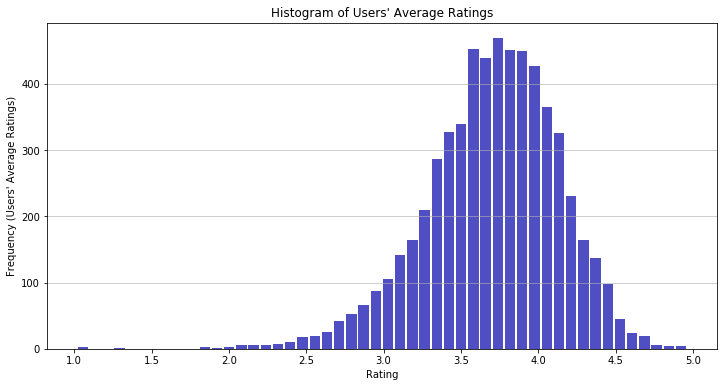

In [10]:
# plot of users' average rating 
plt.hist(ratings_1m.groupby('UserID')['Rating'].mean().tolist(),bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency (Users\' Average Ratings)')
plt.title('Histogram of Users\' Average Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('users_average_rating .png', dpi=100)
plt.show()

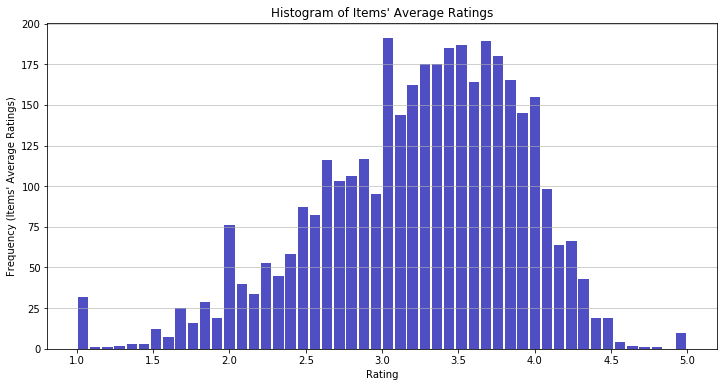

In [11]:
# plot of items' average rating 
plt.hist(ratings_1m.groupby('MovieID')['Rating'].mean().tolist(),bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency (Items\' Average Ratings)')
plt.title('Histogram of Items\' Average Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('items_average_rating.png', dpi=100)
plt.show()

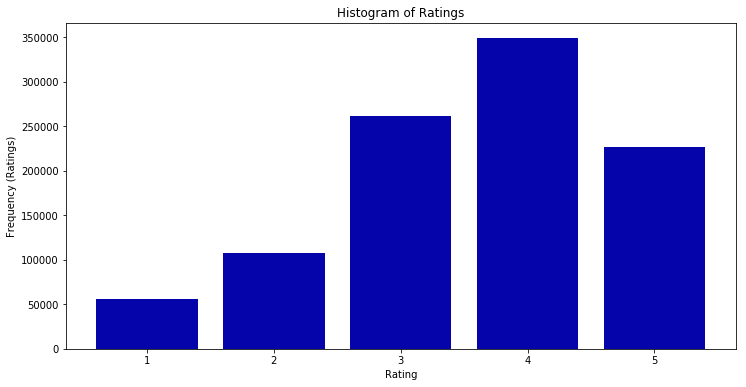

In [12]:
# plot of ratings
plt.bar(sorted(ratings_1m.Rating.unique()),ratings_1m.groupby('Rating')['UserID'].count(), color='#0504aa')
plt.xlabel('Rating')
plt.ylabel('Frequency (Ratings)')
plt.title('Histogram of Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('ratings.png', dpi=100)
plt.show()

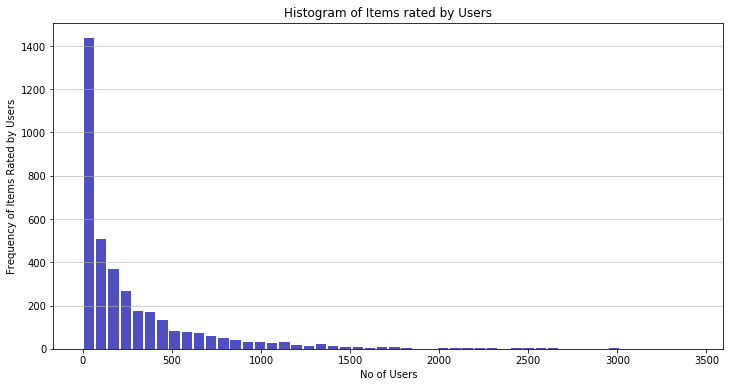

In [13]:
# plot of histogram of items\' rated by users
plt.hist(ratings_1m.groupby('MovieID')['UserID'].count().tolist(),bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('No of Users')
plt.ylabel('Frequency of Items Rated by Users')
plt.title('Histogram of Items rated by Users')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('items_rated_by_users.png', dpi=100)
plt.show()

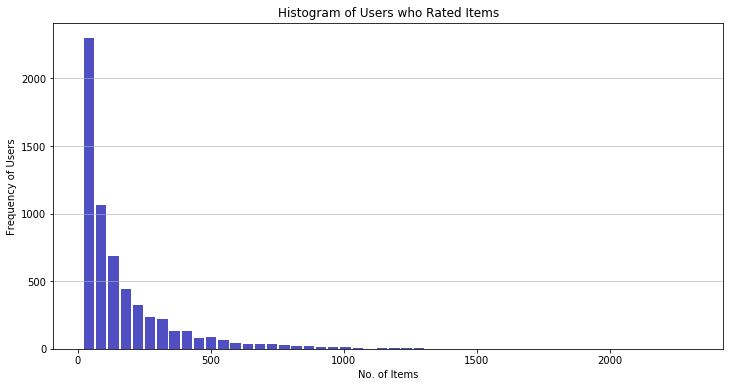

In [14]:
# plot of items rated by users
plt.hist(ratings_1m.groupby('UserID')['MovieID'].count().tolist(),bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('No. of Items')
plt.ylabel('Frequency of Users')
plt.title('Histogram of Users who Rated Items')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('users_who_rated_items.png', dpi=100)
plt.show()

### Wordcloud shows us which genres are most prominent ones among the movies.

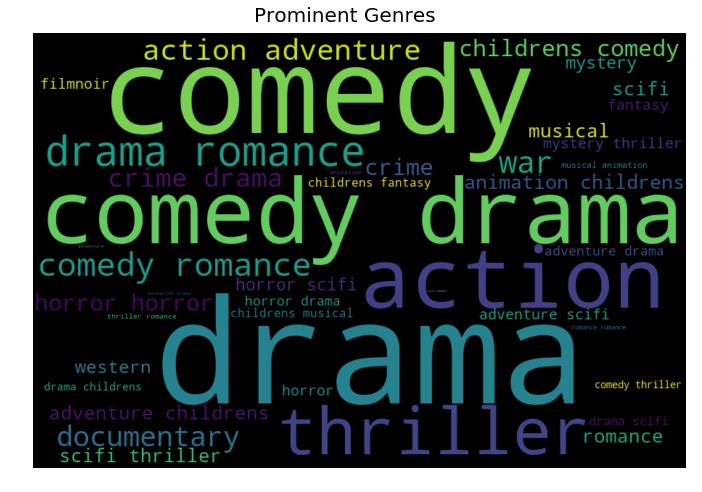

In [15]:
# wordcloud of genres to show prominent genres

x=movies_1m['Genres'].values.tolist()

all_genres=""
for line in x:
    words=str(line).split("|") #sometimes there were error: 'float' object has no attribute 'split'. That's why cast as a string. 
    for word in words:
        word=word.translate(str.maketrans('', '', string.punctuation))
        word=word.lower()
        all_genres=str(all_genres)+" "+str(word)

wordcloud = WordCloud(max_font_size=200, width=900, height=600,collocations=True).generate(all_genres)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.figtext(.5,.9,"Prominent Genres", fontsize=20, ha='center')
fig = plt.gcf()
fig.savefig('wordcloud.png', dpi=100)
plt.show()

# Collaborative Filtering Based Recommendation System

In [16]:
# collaborative filtering using suprise with SVD algorithm

from surprise import Reader, Dataset
from surprise import SVD
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(ratings_1m[["UserID", "MovieID", "Rating"]], reader)

# use SDV algorithm
algo = SVD()

# run 5-fold cross-validation
x=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8865  0.8854  0.8842  0.8854  0.0009  
MAE (testset)     0.6970  0.6954  0.6955  0.6960  0.0008  
Fit time          55.01   53.65   58.99   55.88   2.27    
Test time         2.96    3.79    3.26    3.34    0.34    


### We can see the plot of RMSE & MAE for collaborative filter on 5 fold test set. 

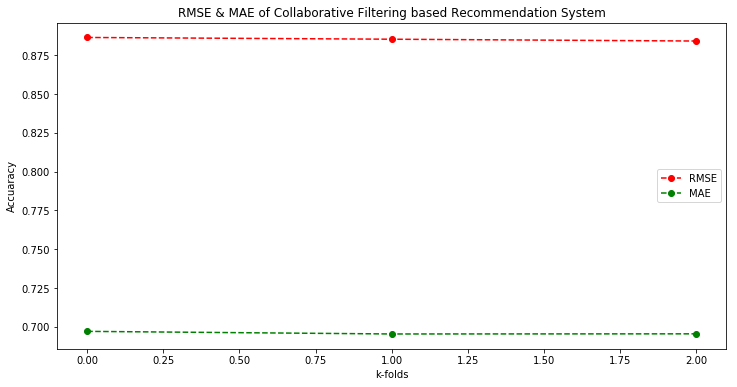

In [17]:
plt.plot(x['test_rmse'], 'ro--', label='RMSE')
plt.plot(x['test_mae'], 'go--', label='MAE')
plt.xlabel('k-folds')
plt.ylabel('Accuaracy')
plt.legend()
plt.title('RMSE & MAE of Collaborative Filtering based Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('cf_rmse_mae.png', dpi=100)
plt.show()

### Getting top 20 recommendation for a particular user

In [18]:
# get top 20 recommendation for a user
titles = movies_1m['Title']
indices = pd.Series(movies_1m.index, index=movies_1m['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres
def cf_top_reco(userId):
    cf_df=pd.DataFrame()\
    
    movie_id_list=ratings_1m['MovieID'].unique().tolist()
    est=[]
    movie_name_list=[]
    actual_score_list=[]
    genre_list=[]
    for i in movie_id_list:
        pred = algo.predict(userId, i, verbose=False)
        est.append(pred[3])
        movie_name = movies_1m[movies_1m.MovieID==i]['Title'].values
        movie_name_list.append(movie_name)
        actual_score =  ratings_1m[(ratings_1m.MovieID==i)&(ratings_1m.UserID==userId)]['Rating'].values
        actual_score_list.append(actual_score)
        genre = movies_1m[movies_1m.MovieID==i]['Genres'].values
        try:
            genre_list.append(genre)
        except:
            genre_list.append('Unavailable')      
    cf_df['movie_id']=movie_id_list
    cf_df['estimated_rating']=est
    cf_df['title']=movie_name_list
    cf_df['actual_rating']=actual_score_list
    cf_df['genres']=genre_list
    cf_df=cf_df.sort_values(['estimated_rating'], ascending=[False])
    return cf_df

### Here we see that collaborative filtering can tell us the movies that a user is likely to rate higher. But it has no way of recommending similar movies to a particular one tailored for the specific user. The genres here are all over the place.

In [19]:
# the function takes userid as input & generates top 20 recommendation for that user. In Actual Rating field we don't 
# have all values populated. This is becasue not all users rated all movies. 
userid=1
cf_top_reco(userid).head(20)

,movie_id,estimated_rating,title,actual_rating,genres
1092,2019,5.000000,[Seven Samurai (The Magnificent Seven) (Shichi...,[],[Action|Drama]
629,904,4.979202,[Rear Window (1954)],[],[Mystery|Thriller]
743,541,4.959595,[Blade Runner (1982)],[],[Film-Noir|Sci-Fi]
1450,2186,4.958008,[Strangers on a Train (1951)],[],[Film-Noir|Thriller]
600,1278,4.954793,[Young Frankenstein (1974)],[],[Comedy|Horror]
167,318,4.912646,"[Shawshank Redemption, The (1994)]",[],[Drama]
648,916,4.896246,[Roman Holiday (1953)],[],[Comedy|Romance]
23,527,4.877704,[Schindler's List (1993)],[5],[Drama|War]
70,3030,4.868160,[Yojimbo (1961)],[],[Comedy|Drama|Western]
1921,950,4.849899,"[Thin Man, The (1934)]",[],[Mystery]


# Content Based Recommendation System

In [20]:
# break up the big genre string into a string array
movies_1m['Genres'] = movies_1m['Genres'].str.split('|')
# convert genres to string value
movies_1m['Genres'] = movies_1m['Genres'].fillna("").astype('str')

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_1m['Genres'])
df = pd.DataFrame(tfidf_matrix.toarray(), columns = tf.get_feature_names())
print(df)
#tfidf_matrix.shape



        action  action adventure  action animation  action children  \
0     0.000000          0.000000               0.0              0.0   
1     0.000000          0.000000               0.0              0.0   
2     0.000000          0.000000               0.0              0.0   
3     0.000000          0.000000               0.0              0.0   
4     0.000000          0.000000               0.0              0.0   
5     0.305869          0.000000               0.0              0.0   
6     0.000000          0.000000               0.0              0.0   
7     0.000000          0.000000               0.0              0.0   
8     1.000000          0.000000               0.0              0.0   
9     0.312081          0.451885               0.0              0.0   
10    0.000000          0.000000               0.0              0.0   
11    0.000000          0.000000               0.0              0.0   
12    0.000000          0.000000               0.0              0.0   
13    

In [48]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:5, :5]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 , 0.23523322],
       [0.14193614, 1.        , 0.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 , 0.38306058],
       [0.1056164 , 0.        , 0.1719888 , 1.        , 0.4489859 ],
       [0.23523322, 0.        , 0.38306058, 0.4489859 , 1.        ]])

In [23]:
# build an 1-dimensional array with movie titles
titles = movies_1m['Title']
movie_id = movies_1m['MovieID']
indices = pd.Series(movies_1m.index, index=movies_1m['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     print(sim_scores)
    sim_scores = sim_scores[1:]
    movie_indices = [i[0] for i in sim_scores]
    cb_df=pd.DataFrame(sim_scores)
    cb_df['title']=titles.iloc[movie_indices].values
    cb_df['movie_id']=movie_id.iloc[movie_indices].values
    cb_df=cb_df.rename(columns={0: "movie_index", 1: "similarity_score"})
    genre_list=[]
    for i in cb_df['movie_id'].values:
        genre = movies_1m[movies_1m.MovieID==i]['Genres'].values
        try:
            genre_list.append(genre)
        except:
            genre_list.append('Unavailable') 
    cb_df['genres']=genre_list
    return cb_df

### While content based has the option to find us the most similar movies to a given one, it has no intution into whether a user will like it or not. 

In [24]:
movies_1m[movies_1m.Title=='Toy Story (1995)']

,MovieID,Title,Genres
0,1,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']"


In [25]:
title='Toy Story (1995)'
genre_recommendations(title).head(20)

,movie_index,similarity_score,title,movie_id,genres
0,1050,1.000000,Aladdin and the King of Thieves (1996),1064,"[['Animation', ""Children's"", 'Comedy']]"
1,2072,1.000000,"American Tail, An (1986)",2141,"[['Animation', ""Children's"", 'Comedy']]"
2,2073,1.000000,"American Tail: Fievel Goes West, An (1991)",2142,"[['Animation', ""Children's"", 'Comedy']]"
3,2285,1.000000,"Rugrats Movie, The (1998)",2354,"[['Animation', ""Children's"", 'Comedy']]"
4,2286,1.000000,"Bug's Life, A (1998)",2355,"[['Animation', ""Children's"", 'Comedy']]"
5,3045,1.000000,Toy Story 2 (1999),3114,"[['Animation', ""Children's"", 'Comedy']]"
6,3542,1.000000,Saludos Amigos (1943),3611,"[['Animation', ""Children's"", 'Comedy']]"
7,3682,1.000000,Chicken Run (2000),3751,"[['Animation', ""Children's"", 'Comedy']]"
8,3685,1.000000,"Adventures of Rocky and Bullwinkle, The (2000)",3754,"[['Animation', ""Children's"", 'Comedy']]"
9,236,0.869805,"Goofy Movie, A (1995)",239,"[['Animation', ""Children's"", 'Comedy', 'Romanc..."


# Hybrid Recommendation System

In [26]:
# an 1-dimensional array with movie titles
titles = movies_1m['Title']
indices = pd.Series(movies_1m.index, index=movies_1m['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres and estimate the rating 
# given the particular user

def hybrid_recommendations(userId,title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:100]
    movie_indices = [i[0] for i in sim_scores]
    hybrid_df=pd.DataFrame(sim_scores)
    hybrid_df['title']=titles.iloc[movie_indices].values
    est=[]
    actual_score_list=[]
    hybrid_df=hybrid_df.rename(columns={0: "movie_index", 1: "similarity_score"})
    for i in movie_indices:
        pred = algo.predict(userId, i, verbose=False)
        est.append(pred[3])
        actual_score =  ratings_1m[(ratings_1m.MovieID==i)&(ratings_1m.UserID==userId)]['Rating'].values
        actual_score_list.append(actual_score)
    hybrid_df['estimated_rating']=est
    hybrid_df['actual_rating']=actual_score_list
    hybrid_df=hybrid_df.sort_values(['similarity_score','estimated_rating'], ascending=[False,False])
    return hybrid_df

### A hybrid system gives us the best of both worlds. It can recommend similar movies to a particular one that the user is most likely to rate high. 

In [27]:
userid=1
title='Toy Story (1995)'
hybrid_recommendations(userid, title).head(20)

,movie_index,similarity_score,title,estimated_rating,actual_rating
0,1050,1.000000,Aladdin and the King of Thieves (1996),4.144167,[]
3,2285,1.000000,"Rugrats Movie, The (1998)",4.082202,[]
2,2073,1.000000,"American Tail: Fievel Goes West, An (1991)",3.976216,[]
7,3682,1.000000,Chicken Run (2000),3.971588,[]
8,3685,1.000000,"Adventures of Rocky and Bullwinkle, The (2000)",3.927850,[]
5,3045,1.000000,Toy Story 2 (1999),3.681530,[]
6,3542,1.000000,Saludos Amigos (1943),3.668329,[]
1,2072,1.000000,"American Tail, An (1986)",3.378847,[]
4,2286,1.000000,"Bug's Life, A (1998)",3.122466,[]
9,236,0.869805,"Goofy Movie, A (1995)",3.494338,[]


# Comparison between Collaborative Filtering Based & Hybrid Recommendation System

### Here we choose top recommended movies by both system for 10 users & calculate RMSE errors for each system for comaprison. 

In [28]:
warnings.filterwarnings("ignore")

In [29]:
rmse_val_sum=0
rmse_count=0
hybrid_rmse_val=[]
            
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# random.seed(0)
# random_users = random.sample(range(6040), 10)

# for j in random_users: 
for j in range(20): 
    x=hybrid_recommendations(j, 'Toy Story (1995)')
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    rmse_val = rmse(np.array(y_pred), np.array(y_actual))
    
    y = float(rmse_val)
    if math.isnan(y)==False:
        hybrid_rmse_val.append(rmse_val)
        rmse_val_sum=rmse_val_sum+rmse_val
        rmse_count=rmse_count+1 
    if rmse_count==10:
        break
    
hybrid_avg_rmse=rmse_val_sum/rmse_count
print("Average RMSE for hybrid system:",hybrid_avg_rmse)

Average RMSE for hybrid system: 0.6103837913822747


In [30]:
rmse_val_sum=0
rmse_count=0
cf_rmse_val=[]

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# random.seed(0)
# random_users = random.sample(range(6040), 10)

# for j in random_users: 
for j in range(20): 
    x=cf_top_reco(j)
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    rmse_val = rmse(np.array(y_pred), np.array(y_actual))
    
    y = float(rmse_val)
    if math.isnan(y)==False:
        cf_rmse_val.append(rmse_val)
        rmse_val_sum=rmse_val_sum+rmse_val
        rmse_count=rmse_count+1 
    if rmse_count==10:
        break
    
cf_avg_rmse=rmse_val_sum/rmse_count
print("Average RMSE for collaborative filtering based system:",cf_avg_rmse)

Average RMSE for collaborative filtering based system: 0.7195832091444867


### From the RMSE plot for 10 users we see that hybrid system has comparatively lower RMSE overall.

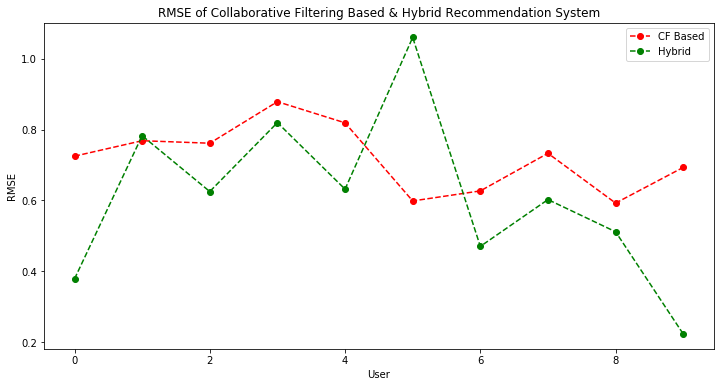

In [31]:
plt.plot(cf_rmse_val, 'ro--', label='CF Based')
plt.plot(hybrid_rmse_val, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_rmse.png', dpi=100)
plt.show()

### The average RMSE plot also shows the superiority of hybrid system.

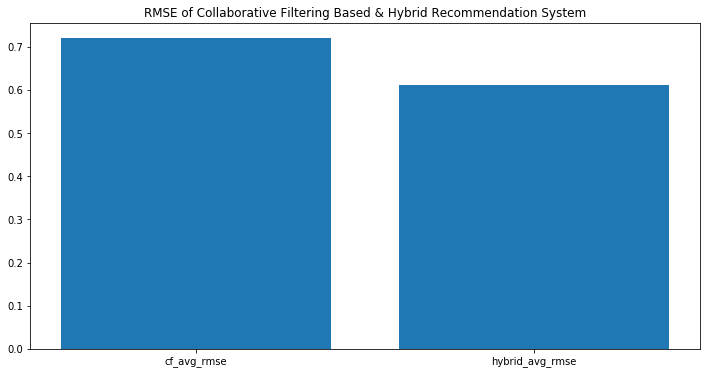

In [32]:
plt.bar(['cf_avg_rmse','hybrid_avg_rmse'],[cf_avg_rmse,hybrid_avg_rmse])
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_rmse_avg.png', dpi=100)
plt.show()

### Here we choose top recommended movies by both system for 10 users & calculate MAE errors for each system for comaprison. 

In [33]:
mae_val_sum=0
mae_count=0
hybrid_mae_val=[]
            
def mae(predictions, targets):
    return (abs(predictions - targets).mean())

# random.seed(100)
# random_users = random.sample(range(6040), 10)

# for j in random_users: 
for j in range(20): 
    x=hybrid_recommendations(j, 'Toy Story (1995)')
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    mae_val = mae(np.array(y_pred), np.array(y_actual))
    
    y = float(mae_val)
    if math.isnan(y)==False:
        hybrid_mae_val.append(mae_val)
        mae_val_sum=mae_val_sum+mae_val
        mae_count=mae_count+1 
    if mae_count==10:
        break
    
hybrid_avg_mae=mae_val_sum/mae_count
print("Average MAE for hybrid system:",hybrid_avg_mae)

Average MAE for hybrid system: 0.5368483608080034


In [34]:
mae_val_sum=0
mae_count=0
cf_mae_val=[]

def mae(predictions, targets):
    return (abs(predictions - targets).mean())

# random.seed(0)
# random_users = random.sample(range(6040), 10)

# for j in random_users: 
for j in range(20): 
    x=cf_top_reco(j)
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    mae_val = mae(np.array(y_pred), np.array(y_actual))
    
    y = float(mae_val)
    if math.isnan(y)==False:
        cf_mae_val.append(mae_val)
        mae_val_sum=mae_val_sum+mae_val
        mae_count=mae_count+1 
    if mae_count==10:
        break
    
cf_avg_mae=mae_val_sum/mae_count
print("Average MAE for collaborative filtering based system:",cf_avg_mae)

Average MAE for collaborative filtering based system: 0.5654935584286477


### From the MAE plot for 10 users we see that hybrid system has comparatively lower MAE overall.

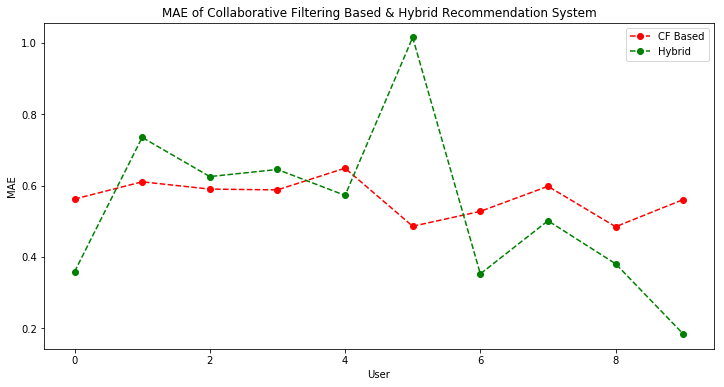

In [35]:
plt.plot(cf_mae_val, 'ro--', label='CF Based')
plt.plot(hybrid_mae_val, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_mae.png', dpi=100)
plt.show()

### The average MAE plot also shows the superiority of hybrid system.

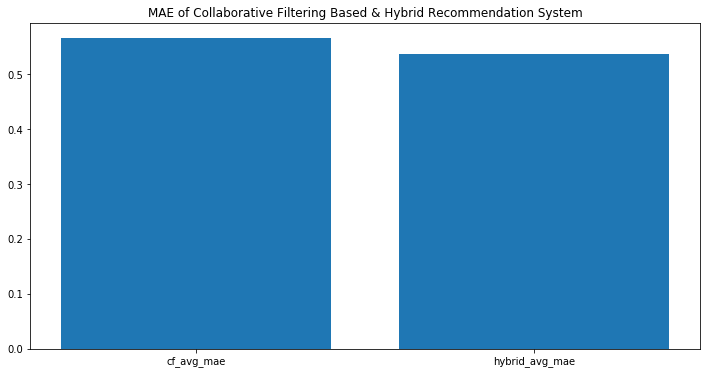

In [36]:
plt.bar(['cf_avg_mae','hybrid_avg_mae'],[cf_avg_mae,hybrid_avg_mae])
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_mae_avg.png', dpi=100)
plt.show()

### Let's consider 5 set of users with a batch size of 5 for whom we want to do the same test

### RMSE

In [37]:
all_hybrid_avg_rmse=[]  
for k in range(5):
    rmse_val_sum=0
    rmse_count=0
    hybrid_rmse_val=[]

    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10): 
        x=hybrid_recommendations(j, 'Toy Story (1995)')
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        rmse_val = rmse(np.array(y_pred), np.array(y_actual))

        y = float(rmse_val)
        if math.isnan(y)==False:
            hybrid_rmse_val.append(rmse_val)
            rmse_val_sum=rmse_val_sum+rmse_val
            rmse_count=rmse_count+1 
        if rmse_count==5:
            break

    hybrid_avg_rmse=rmse_val_sum/rmse_count
    print("Average RMSE for hybrid system:",hybrid_avg_rmse)
    all_hybrid_avg_rmse.append(hybrid_avg_rmse)

all_hybrid_avg_rmse_one=sum(all_hybrid_avg_rmse)/len(all_hybrid_avg_rmse)

Average RMSE for hybrid system: 0.6474500810156366
Average RMSE for hybrid system: 0.520255412829487
Average RMSE for hybrid system: 0.7908183414926818
Average RMSE for hybrid system: 0.6254089958921834
Average RMSE for hybrid system: 0.8187322205512342


In [38]:
all_cf_avg_rmse=[]  
for k in range(5):
    rmse_val_sum=0
    rmse_count=0
    cf_rmse_val=[]

    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10): 
        x=cf_top_reco(j)
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        rmse_val = rmse(np.array(y_pred), np.array(y_actual))

        y = float(rmse_val)
        if math.isnan(y)==False:
            cf_rmse_val.append(rmse_val)
            rmse_val_sum=rmse_val_sum+rmse_val
            rmse_count=rmse_count+1 
        if rmse_count==5:
            break
            
    cf_avg_rmse=rmse_val_sum/rmse_count
    print("Average RMSE for collaborative filtering based system:",cf_avg_rmse)
    all_cf_avg_rmse.append(cf_avg_rmse)
    
all_cf_avg_rmse_one=sum(all_cf_avg_rmse)/len(all_cf_avg_rmse)

Average RMSE for collaborative filtering based system: 0.7904410458385763
Average RMSE for collaborative filtering based system: 0.8342004470776402
Average RMSE for collaborative filtering based system: 0.7830373552165175
Average RMSE for collaborative filtering based system: 0.7708260758564822
Average RMSE for collaborative filtering based system: 0.7941999909305169


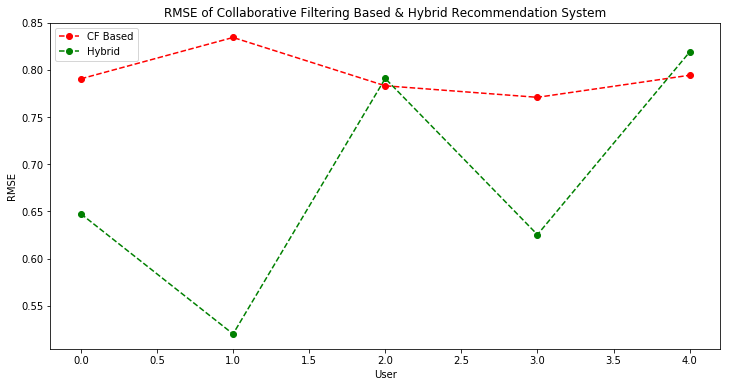

In [39]:
plt.plot(all_cf_avg_rmse, 'ro--', label='CF Based')
plt.plot(all_hybrid_avg_rmse, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('all_hybrid_cf_rmse.png', dpi=100)
plt.show()

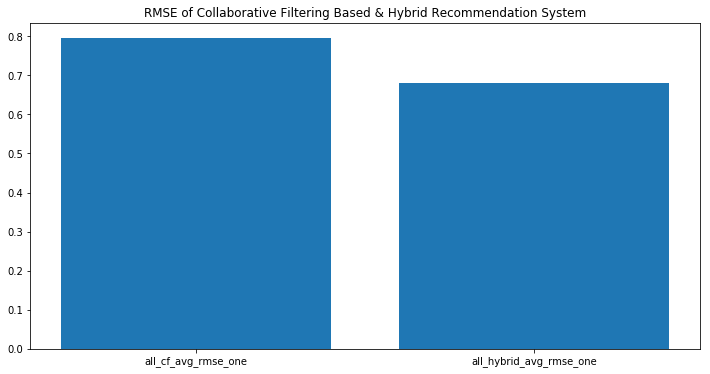

In [40]:
plt.bar(['all_cf_avg_rmse_one','all_hybrid_avg_rmse_one'],[all_cf_avg_rmse_one,all_hybrid_avg_rmse_one])
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_rmse_avg_one.png', dpi=100)
plt.show()

### MAE

In [41]:
all_hybrid_avg_mae=[]  
for k in range(5):
    mae_val_sum=0
    mae_count=0
    hybrid_mae_val=[]

    def mae(predictions, targets):
        return (abs(predictions - targets).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10): 
        x=hybrid_recommendations(j, 'Toy Story (1995)')
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        mae_val = mae(np.array(y_pred), np.array(y_actual))

        y = float(mae_val)
        if math.isnan(y)==False:
            hybrid_mae_val.append(mae_val)
            mae_val_sum=mae_val_sum+mae_val
            mae_count=mae_count+1 
        if mae_count==5:
            break

    hybrid_avg_mae=mae_val_sum/mae_count
    print("Average MAE for hybrid system:",hybrid_avg_mae)
    all_hybrid_avg_mae.append(hybrid_avg_mae)
    
all_hybrid_avg_mae_one=sum(all_hybrid_avg_mae)/len(all_hybrid_avg_rmse)

Average MAE for hybrid system: 0.5870321029286607
Average MAE for hybrid system: 0.45201214318958793
Average MAE for hybrid system: 0.6717023283155925
Average MAE for hybrid system: 0.5266179283819507
Average MAE for hybrid system: 0.7243828749481048


In [42]:
all_cf_avg_mae=[]  
for k in range(5):
    mae_val_sum=0
    mae_count=0
    cf_mae_val=[]

    def mae(predictions, targets):
        return (abs(predictions - targets).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10): 
        x=cf_top_reco(j)
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        mae_val = mae(np.array(y_pred), np.array(y_actual))

        y = float(mae_val)
        if math.isnan(y)==False:
            cf_mae_val.append(mae_val)
            mae_val_sum=mae_val_sum+mae_val
            mae_count=mae_count+1 
        if mae_count==5:
            break

    cf_avg_mae=mae_val_sum/mae_count
    print("Average MAE for collaborative filtering based system:",cf_avg_mae)
    all_cf_avg_mae.append(cf_avg_mae)
    
all_cf_avg_mae_one=sum(all_cf_avg_mae)/len(all_cf_avg_mae)

Average MAE for collaborative filtering based system: 0.5997131076533078
Average MAE for collaborative filtering based system: 0.6605426750362641
Average MAE for collaborative filtering based system: 0.6413255428788125
Average MAE for collaborative filtering based system: 0.6357069196373936
Average MAE for collaborative filtering based system: 0.6623851073143658


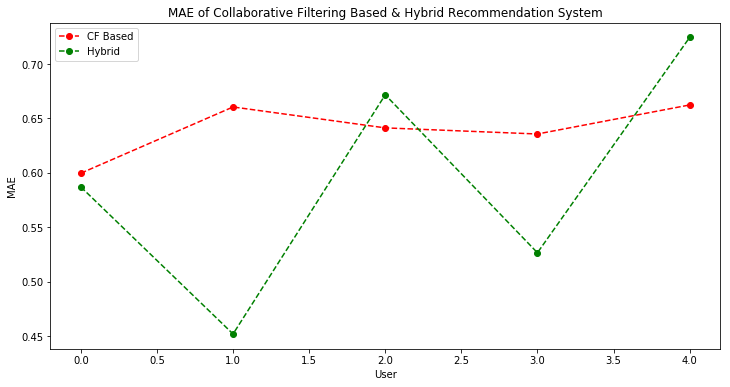

In [43]:
plt.plot(all_cf_avg_mae, 'ro--', label='CF Based')
plt.plot(all_hybrid_avg_mae, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('set_all_hybrid_cf_mae.png', dpi=100)
plt.show()

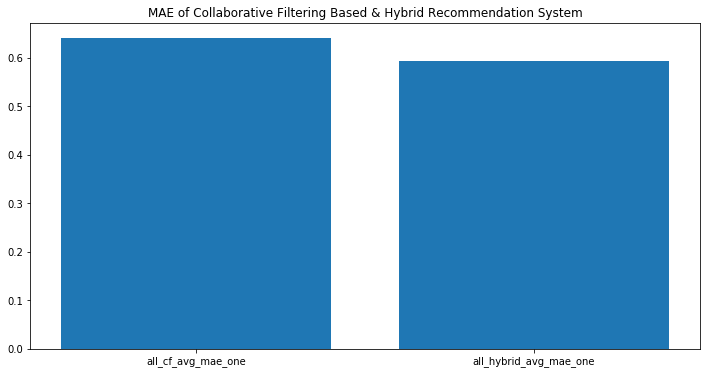

In [44]:
plt.bar(['all_cf_avg_mae_one','all_hybrid_avg_mae_one'],[all_cf_avg_mae_one,all_hybrid_avg_mae_one])
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_mae_avg_one.png', dpi=100)
plt.show()

### Here we have made a total of 4 different comparisons

### 1. We have compared the RMSE between Collaborative Filtering Based and Hybrid Recommendation System. Hybrid System clearly performed better with lower RMSE.
### 2. We have compared the MAE between Collaborative Filtering Based and Hybrid Recommendation System. Hybrid System clearly performed better with lower MAE.
### 3. Next we selected 5 sets of user groups where each group contains 5 users. We calculated the RMSE of these sets of users & the comparison shows Hybrid system performs better comparatively.
### 4. We did the same for MAE with 5 sets of user groups. Hybrid system came on top here too overall.

### Based on the above tests, we can conclude that Hybrid system shows better performance both qualitatively & quantitatively.  